/opt/homebrew/anaconda3/envs/python3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch [1/5], Train Loss: 40.5737, Val Loss: 47.6883
Epoch [2/5], Train Loss: 39.5906, Val Loss: 46.8297
Epoch [3/5], Train Loss: 38.4392, Val Loss: 45.6984
Epoch [4/5], Train Loss: 36.7963, Val Loss: 44.0993
Epoch [5/5], Train Loss: 35.0772, Val Loss: 41.8134
Test MSE: 8.8596
Test MAE: 2.9455
Test R^2: nan


/opt/homebrew/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


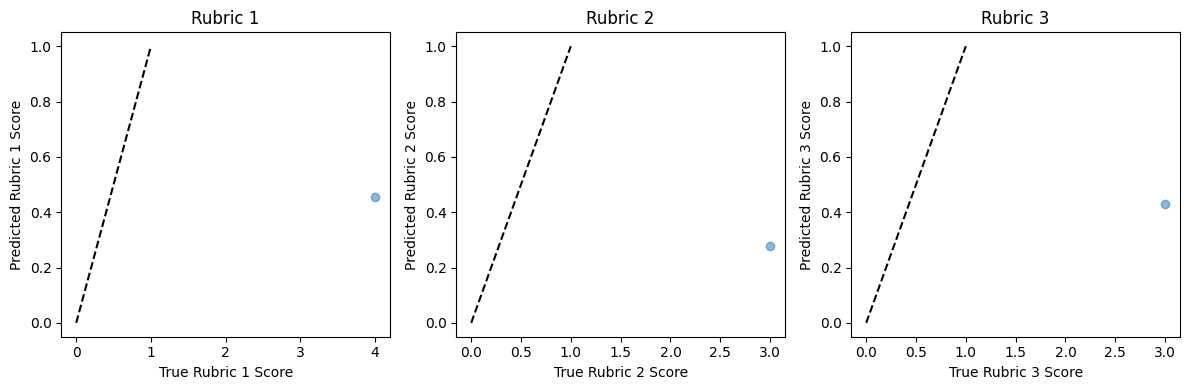


예측 결과:
주제글: 새로운 주제글 1
모범글: 새로운 모범글 1
응답글: 새로운 응답글 1
예측 점수 - 루블릭1: 0.33, 루블릭2: 0.17, 루블릭3: 0.36
---
주제글: 새로운 주제글 2
모범글: 새로운 모범글 2
응답글: 새로운 응답글 2
예측 점수 - 루블릭1: 0.34, 루블릭2: 0.17, 루블릭3: 0.35
---

모델 성능 정리:
Test MSE: 8.8596
Test MAE: 2.9455
Test R^2: nan


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

class ScoringDataset:
    def __init__(self, file_path):
        self.data = pd.read_excel(file_path)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        self.max_len = 512
        self.X = None
        self.y = None

    def preprocess(self):
        self.data['text'] = self.data['주제글'] + ' ' + self.data['모범글'] + ' ' + self.data['수험자 응답글']
        self.X = self.data['text'].values
        self.y = self.data[['루블릭1점수', '루블릭2점수', '루블릭3점수']].values

    def tokenize(self):
        X_tokenized = self.tokenizer.batch_encode_plus(
            self.X.tolist(),
            max_length=self.max_len,
            padding=True,
            truncation=True,
            return_tensors='pt'
        )
        self.X = X_tokenized['input_ids']

    def split_data(self, test_size=0.2, val_size=0.2):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)
        return X_train, X_val, X_test, torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

class ScoringModel(nn.Module):
    def __init__(self, hidden_dim):
        super(ScoringModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.hidden = nn.Linear(self.bert.config.hidden_size, hidden_dim)
        self.output1 = nn.Linear(hidden_dim, 1)
        self.output2 = nn.Linear(hidden_dim, 1)
        self.output3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        outputs = self.bert(x)
        pooled_output = outputs[1]
        hidden = torch.relu(self.hidden(pooled_output))
        output1 = self.output1(hidden)
        output2 = self.output2(hidden)
        output3 = self.output3(hidden)
        return output1, output2, output3

class Trainer:
    def __init__(self, model, X_train, y_train, X_val, y_val, epochs=5, batch_size=16):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.epochs = epochs
        self.batch_size = batch_size
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=2e-5)

    def train(self):
        self.model.train()
        for epoch in range(self.epochs):
            for i in range(0, len(self.X_train), self.batch_size):
                batch_X = self.X_train[i:i + self.batch_size]
                batch_y = self.y_train[i:i + self.batch_size]

                self.optimizer.zero_grad()
                output1, output2, output3 = self.model(batch_X)
                loss1 = self.criterion(output1, batch_y[:, 0].unsqueeze(1))
                loss2 = self.criterion(output2, batch_y[:, 1].unsqueeze(1))
                loss3 = self.criterion(output3, batch_y[:, 2].unsqueeze(1))
                loss = loss1 + loss2 + loss3
                loss.backward()
                self.optimizer.step()

            with torch.no_grad():
                self.model.eval()
                output1, output2, output3 = self.model(self.X_val)
                loss1 = self.criterion(output1, self.y_val[:, 0].unsqueeze(1))
                loss2 = self.criterion(output2, self.y_val[:, 1].unsqueeze(1))
                loss3 = self.criterion(output3, self.y_val[:, 2].unsqueeze(1))
                val_loss = loss1 + loss2 + loss3
                self.model.train()

                print(f"Epoch [{epoch + 1}/{self.epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

class Evaluator:
    def __init__(self, model, X_test, y_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test.numpy()

    def evaluate(self):
        self.model.eval()
        with torch.no_grad():
            output1, output2, output3 = self.model(self.X_test)
            y_pred = torch.cat((output1, output2, output3), dim=1).numpy()

        mse = mean_squared_error(self.y_test, y_pred)
        mae = mean_absolute_error(self.y_test, y_pred)
        r2 = r2_score(self.y_test, y_pred)

        print(f'Test MSE: {mse:.4f}')
        print(f'Test MAE: {mae:.4f}')
        print(f'Test R^2: {r2:.4f}')

        plt.figure(figsize=(12, 4))
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.scatter(self.y_test[:, i], y_pred[:, i], alpha=0.5)
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel(f'True Rubric {i + 1} Score')
            plt.ylabel(f'Predicted Rubric {i + 1} Score')
            plt.title(f'Rubric {i + 1}')
        plt.tight_layout()
        plt.show()

        return mse, mae, r2

class Predictor:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.max_len = 512

    def predict_scores(self, prompts, exemplars, responses):
        X_new = [prompt + ' ' + exemplar + ' ' + response for prompt, exemplar, response in zip(prompts, exemplars, responses)]

        X_new_tokenized = self.tokenizer.batch_encode_plus(
            X_new,
            max_length=self.max_len,
            padding=True,
            truncation=True,
            return_tensors='pt'
        )

        X_new_tensor = X_new_tokenized['input_ids']

        self.model.eval()
        with torch.no_grad():
            output1, output2, output3 = self.model(X_new_tensor)
            y_pred = torch.cat((output1, output2, output3), dim=1).numpy()

        return y_pred

def main():
    file_path = 'scoring_data.xlsx'
    dataset = ScoringDataset(file_path)
    dataset.preprocess()
    dataset.tokenize()
    X_train, X_val, X_test, y_train, y_val, y_test = dataset.split_data()

    hidden_dim = 64

    model = ScoringModel(hidden_dim)
    trainer = Trainer(model, X_train, y_train, X_val, y_val, epochs=5, batch_size=16)
    trainer.train()

    evaluator = Evaluator(model, X_test, y_test)
    mse, mae, r2 = evaluator.evaluate()

    predictor = Predictor(model, dataset.tokenizer)
    prompts = ['새로운 주제글 1', '새로운 주제글 2']
    exemplars = ['새로운 모범글 1', '새로운 모범글 2']
    responses = ['새로운 응답글 1', '새로운 응답글 2']
    y_pred = predictor.predict_scores(prompts, exemplars, responses)

    print('\n예측 결과:')
    for i in range(len(prompts)):
        print(f'주제글: {prompts[i]}')
        print(f'모범글: {exemplars[i]}')
        print(f'응답글: {responses[i]}')
        print(f'예측 점수 - 루블릭1: {y_pred[i][0]:.2f}, 루블릭2: {y_pred[i][1]:.2f}, 루블릭3: {y_pred[i][2]:.2f}')
        print('---')
        
    print('\n모델 성능 정리:')
    print(f'Test MSE: {mse:.4f}')
    print(f'Test MAE: {mae:.4f}')
    print(f'Test R^2: {r2:.4f}')

if __name__ == '__main__':
    main()